In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 计算图
## 计算图

In [2]:
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)

a = torch.add(w, x)
b = torch.add(w, 1)
y = torch.mul(a, b)

y.backward()
print(w.grad)

tensor([5.])


1. 叶子节点这个属性(还记得张量的属性里面有一个 is_leaf 吗）: **叶子节点：用户创建的节点**， 比如上面的 x 和 w。叶子节点是非常关键的，在上面的正向计算和反向计算中，其实都是依赖于我们叶子节点进行计算的。is_leaf: 指示张量是否是叶子节点。

为什么要设置叶子节点的这个概念的？主要是为了节省内存，因为我们在反向传播完了之后，非叶子节点的梯度是默认被释放掉的。我们可以根据上面的那个计算过程，来看看 w，x, a, b, y 的 is_leaf 属性，和它们各自的梯度情况：

In [3]:
# 查看叶子结点
print("is_leaf:\n", w.is_leaf, x.is_leaf, a.is_leaf, b.is_leaf, y.is_leaf)
# 查看梯度， 默认是只保留叶子节点的梯度的
print("gradient:\n", w.grad, x.grad, a.grad, b.grad, y.grad)

is_leaf:
 True True False False False
gradient:
 tensor([5.]) tensor([2.]) None None None


In [4]:
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)

a = torch.add(w, x)
a.retain_grad()
b = torch.add(w, 1)
y = torch.mul(a, b)

y.backward()
#查看梯度， 默认是只保留叶子节点的梯度的
print("gradient:\n", w.grad, x.grad, a.grad, b.grad, y.grad)

gradient:
 tensor([5.]) tensor([2.]) tensor([2.]) None None


2. grad_fn：记录创建该张量时所用的方法（函数），记录这个方法主要「用于梯度的求导」。要不然怎么知道具体是啥运算？

In [5]:
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)

a = torch.add(w, x)
a.retain_grad()
b = torch.add(w, 1)
y = torch.mul(a, b)

y.backward()

# 查看 grad_fn   这个表示怎么得到的
print("grad_fn:\n", w.grad_fn, x.grad_fn, a.grad_fn, b.grad_fn, y.grad_fn)

grad_fn:
 None None <AddBackward0 object at 0x0000022060E5C358> <AddBackward0 object at 0x0000022060E5C3C8> <MulBackward0 object at 0x0000022060E5C400>


## 动态图
根据计算图的搭建方式，可以将计算图分为动态图和静态图。
- 静态图：先搭建图，后运算。高效，不灵活（TensorFlow）
- 动态图：运算与搭建同时进行。灵活，易调节（Pytorch）

In [6]:
# import tensorflow as tf
# # 声明两个常量
# w = tf.constant(1.)
# x = tf.constant(2.)

# # 搭建静态图
# a = tf.add(w, x)
# b = tf.add(w, 1)
# y = tf.multiply(a, b)

# # 这时候还没开始计算
# print(y)   # Tensor("Mul_4:0", shape=(), dtype=float32)， 只是计算图的一个节点

# with tf.Session() as sess:  
#     print(sess.run(y))   # 这里才开始进行计算， 6.0

In [7]:
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)

a = torch.add(w, x)
b = torch.add(w, 1)
y = torch.mul(a, b)
print(y)    # tensor([6.], grad_fn=<MulBackward0>)

tensor([6.], grad_fn=<MulBackward0>)


# 自动求导机制

In [8]:
y0 = torch.mul(a, b)  # y0=(x + w) * (w + 1)   dy0 / dw = 5
y1 =torch.add(a, b)   # y1=(x + w) + (w + 1)   dy1 / dw = 2

loss = torch.cat([y0, y1], dim=0)  # [y0, y1]

In [9]:
grad_tensors = torch.tensor([1., 1.])
loss.backward(gradient=grad_tensors)    
print(w.grad)   #  这时候会是tensor([7.])   5+2

# grad_tensors = torch.tensor([1., 2.])
# loss.backward(gradient=grad_tensors)    
# print(w.grad)   #  这时候会是tensor([9.])   5+2*2

tensor([7.])


In [10]:
x = torch.tensor([3.], requires_grad=True)
y = torch.pow(x, 2)  # y = x ^ 2

# 一次求导
grad_1 = torch.autograd.grad(y, x, create_graph=True)
print(grad_1)

# 二次求导
grad_2 = torch.autograd.grad(grad_1[0], x)
print(grad_2)

(tensor([6.], grad_fn=<MulBackward0>),)
(tensor([2.]),)


In [11]:
x1 = torch.tensor(1.0, requires_grad=True)
x2 = torch.tensor(2.0, requires_grad=True)

y1 = x1 * x2
y2 = x1 + x2


# 同时对多个自变量求导
(dy1_dx1, dy1_dx2) = torch.autograd.grad(outputs=y1, inputs=[x1, x2], retain_graph=True)
print(dy1_dx1, dy1_dx2)

# 如果有多个因变量，相当于把多个因变量的梯度结果求和
(dy12_dx1, dy12_dx2) = torch.autograd.grad(outputs=[y1, y2], inputs=[x1, x2])
print(dy12_dx1, dy12_dx2)

tensor(2.) tensor(1.)
tensor(3.) tensor(2.)


1. 关于 Pytorch 的自动求导系统要注意：

梯度不自动清零：就是每一次反向传播，梯度都会叠加上去，这个要注意，举个例子：

In [12]:
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)

for i in range(4):
    a = torch.add(w, x)
    b = torch.add(w, 1)
    y = torch.mul(a, b)
    
    y.backward()
    print(w.grad)

tensor([5.])
tensor([10.])
tensor([15.])
tensor([20.])


In [13]:
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)

for i in range(4):
    a = torch.add(w, x)
    b = torch.add(w, 1)
    y = torch.mul(a, b)
    
    y.backward()
    print(w.grad)
    
    w.grad.zero_()

tensor([5.])
tensor([5.])
tensor([5.])
tensor([5.])


2. 依赖于叶子节点的节点，requires_grad 默认为 True，这是啥意思？

In [14]:
w = torch.tensor([1.], requires_grad=True)
b = torch.tensor([2.], requires_grad=True)

a = torch.add(w, x)
b = torch.add(w, 1)

y = torch.mul(a, b)
print(w.requires_grad, a.requires_grad, b.requires_grad)

True True True


3. 叶子节点不可执行 in-place（这个 in-place 就是原位操作）

In [15]:
a = torch.ones((1, 0))
print(id(a), a)

a = a + torch.ones((1,))
print(id(a), a)

# 原地修改
a = torch.ones((1,))
print(id(a), a)
a += torch.ones((1,))
print(id(a), a)

2338088000032 tensor([], size=(1, 0))
2338088000104 tensor([], size=(1, 0))
2338088000176 tensor([1.])
2338088000176 tensor([2.])


# 逻辑回归模型

1. 数据生成 这里我们使用随机生成的方式，生成 2 类样本（用 0 和 1 表示）， 每一类样本 100 个， 每一个样本两个特征。

In [16]:
"""数据生成"""
torch.manual_seed(1)

sample_nums = 100
mean_value = 1.7
bias = 1

n_data = torch.ones(sample_nums, 2)
x0 = torch.normal(mean_value * n_data, 1) + bias   # 类别0，数据shape=(100,2)
y0 = torch.zeros(sample_nums)                      # 类别0，数据shape=(100,1)

x1 = torch.normal(-mean_value * n_data, 1) + bias  # 类别1，数据shape=(100,2)
y1 = torch.ones(sample_nums)                       # 类别1，数据shape=(100,1) 

train_x = torch.cat([x0, x1], dim=0)
train_y = torch.cat([y0, y1], dim=0)

2. 建立模型 这里我们使用两种方式建立我们的逻辑回归模型，一种是 Pytorch 的 sequential 方式，这种方式就是简单，易懂，就类似于搭积木一样，一层一层往上搭。另一种方式是继承 nn.Module 这个类搭建模型，这种方式非常灵活，能够搭建各种复杂的网络。

In [17]:
"""建立模型"""
class LR(torch.nn.Module):
    def __init__(self):
        super(LR, self).__init__()
        self.features = torch.nn.Linear(2, 1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.features(x)
        x = self.sigmoid(x)
        return x
    
lr_net = LR()

In [18]:
lr_net = torch.nn.Sequential(torch.nn.Linear(2, 1),
                             torch.nn.Sigmoid())

3. 选择损失函数

In [19]:
"""选择损失函数"""
loss_fn = torch.nn.BCELoss()

4. 选择优化器

In [20]:
"""选择优化器"""
lr = 0.01
optimizer = torch.optim.SGD(lr_net.parameters(), lr=lr, momentum=0.9)

5. 迭代训练模型

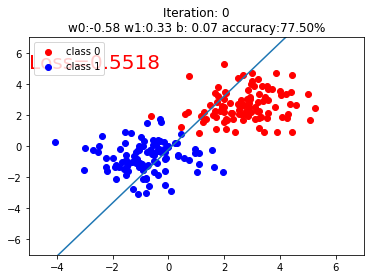

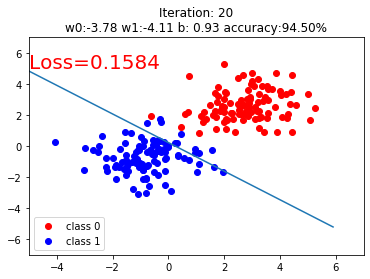

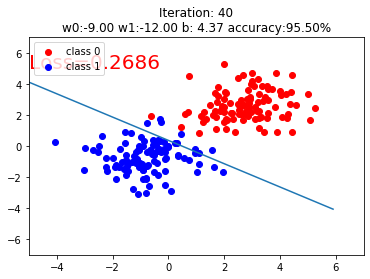

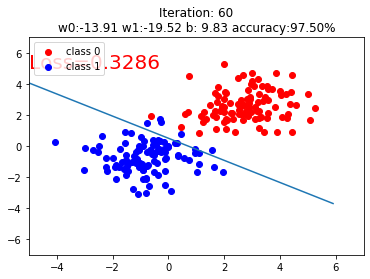

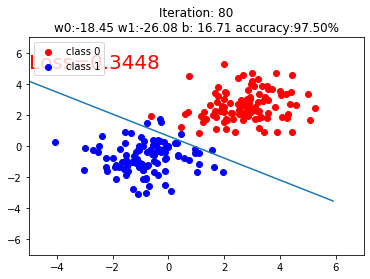

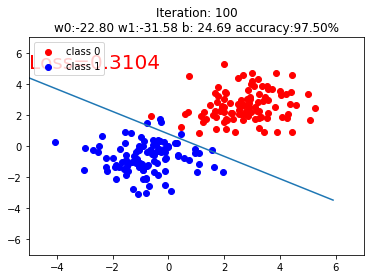

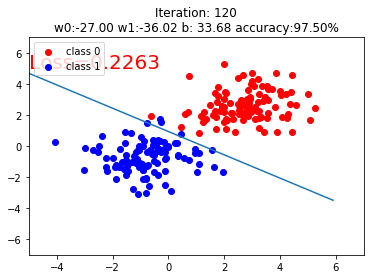

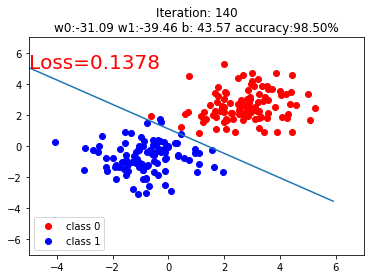

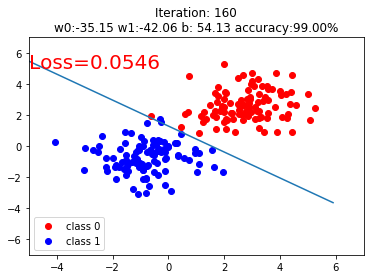

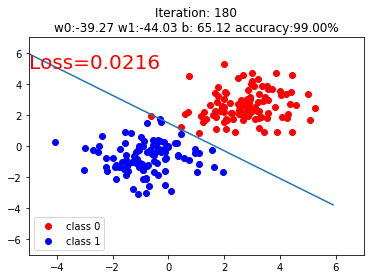

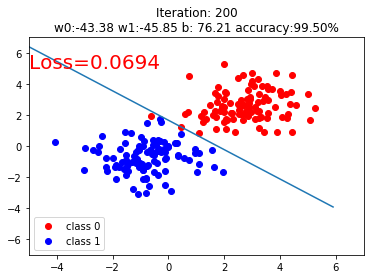

In [21]:
"""模型训练"""
for iteration in range(1000):
    # 前向传播
    y_pred = lr_net(train_x)
    
    # 计算loss
    loss = loss_fn(y_pred.squeeze(), train_y)
    
    # 反向传播
    loss.backward()
    
    # 更新参数
    optimizer.step()
    
    # 绘图
    if iteration % 20 == 0:

        mask = y_pred.ge(0.5).float().squeeze()  # 以0.5为阈值进行分类
        correct = (mask == train_y).sum()  # 计算正确预测的样本个数
        acc = correct.item() / train_y.size(0)  # 计算分类准确率

        plt.scatter(x0.data.numpy()[:, 0], x0.data.numpy()[:, 1], c='r', label='class 0')
        plt.scatter(x1.data.numpy()[:, 0], x1.data.numpy()[:, 1], c='b', label='class 1')
        
        w0, w1 = list(lr_net.parameters())[0][0, 0], list(lr_net.parameters())[0][0, 1]
        plot_b = float(list(lr_net.parameters())[1])
        plot_x = np.arange(-6, 6, 0.1)
        plot_y = (-w0.detach().numpy() * plot_x - plot_b) / w1.detach().numpy()

        plt.xlim(-5, 7)
        plt.ylim(-7, 7)
        plt.plot(plot_x, plot_y)

        plt.text(-5, 5, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color': 'red'})
        plt.title("Iteration: {}\nw0:{:.2f} w1:{:.2f} b: {:.2f} accuracy:{:.2%}".format(iteration, w0, w1, plot_b, acc))
        plt.legend()

        plt.show()
        plt.pause(0.5)

        if acc > 0.99:
            break